In [1]:
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter1d
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf
import pingouin as pg
import trial_correlates as tc
import tqdm
import misc

import switch_analysis_one_session as saos
reload(saos)

reload(misc)

from collections import OrderedDict

from scipy.spatial.distance import pdist, squareform, dice

67 sessions!
67 sessions!


In [119]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



In [13]:

db_sorted = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
ii=1
data_dir_full = db_sorted['data_dir_full'][ii]
ani = db_sorted.index[ii][0]#'e15_13f1'#'e13_26m1'
sess=db_sorted['sess_name'][ii]#'e15_13f1_220117'#'e13_26m1_210913'
print(sess)

e15_13f1_220117


In [14]:
pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


In [15]:
switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              save_fn=saos.SAVE_FN(saos.FR_KEY),load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---


In [16]:
# load data
mat_to_return=prep.load_stuff(data_dir_full)
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']


prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df=dpp.group_into_trialtype(spk_beh_df)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df'].as_dataframe()
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']

In [17]:
reload(pa)
cell_cols = cell_cols_d['pyr']
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=1.,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


cant format into a dataframe
cant format into a dataframe


In [18]:
reload(pa)
fr_map_concat,index_within_to_trial_index_df = pa.concat_fr_map_trial_df_d(fr_map_trial_df_d,spk_beh_df)

# decompose variability

In [19]:
Xhat = pd.concat(switch_res['avg']['X'][0.3],axis=0)

fr_trial = pd.concat(pf_res['avg']['params'],axis=0).loc[(slice(None),slice(None),'fr_mean')]

In [42]:
tt=1
Xhat_one = Xhat.loc[0,1].dropna(axis=1)
fr_trial_one = fr_trial.loc[0,1].dropna(axis=1)
def decompose_variability_onetrialtype(Xhat_one,fr_trial_one):
    '''
    get: total variance, variance in fit, average squared residual, mean, normalized by mean
    '''
    res = {}
    res['tot_var'] = fr_trial_one.var(axis=1,ddof=0) # ddof=0 to make the equation holds; alternatively could have the mean of resid2 replaced by /(Ntrial-1)
    res['mean'] = fr_trial_one.mean(axis=1)
    Xhat_rescaled_back = Xhat_one * fr_trial_one.max(axis=1).values[:,None] # inverse of the max normalization
    res['fit_var'] = Xhat_rescaled_back.var(axis=1,ddof=0)
    resid = fr_trial_one - Xhat_rescaled_back
    res['resid2_mean'] = (resid**2).mean(axis=1)
    res['fit_var_ratio'] = res['fit_var'] / res['tot_var']
    res['resid2_mean_ratio'] =1-res['fit_var_ratio']
    for k in ['tot_var','fit_var','resid2_mean']:
        res[k+'_norm'] = res[k] / res['mean']
    res = pd.DataFrame(res)
    return res

def post_decomp_corr(res,pcorr_vars=['mean','fit_var_norm','resid2_mean_norm']):
    all_corr = res.rcorr(stars=False)
    p_corr = res[pcorr_vars].pcorr()
    corr_res = {'all_corr':all_corr,'p_corr':p_corr}
    return corr_res
    
    

In [48]:
import tqdm

In [50]:
Xhat

0         1         2         3         4         5   \
0 0 39  1  0.544850  0.544850  0.544850  0.544850  0.544850  0.544850   
        2  0.783161  0.783161  0.783161  0.783161  0.783161  0.783161   
        3  0.533123  0.533123  0.533123  0.533123  0.533123  0.533123   
        4  0.504977  0.504977  0.504977  0.504977  0.504977  0.504977   
    40  0  0.580160  0.580160  0.580160  0.580160  0.580160  0.580160   
...             ...       ...       ...       ...       ...       ...   
  1 355 0  0.514782  0.514782  0.514782  0.514782  0.514782  0.514782   
    356 0  0.056199  0.056199  1.000000  0.218323  0.218323  0.218323   
    357 0  0.000000  0.929088  0.929088  0.275064  0.275064  0.275064   
    361 2  0.073557  0.073557  0.073557  0.073557  0.073557  0.073557   
    362 0  0.179653  0.179653  0.179653  0.179653  0.179653  0.179653   

                 6         7         8         9         10        11  \
0 0 39  1  0.544850  0.544850  0.544850  0.544850  0.544850  0.544850   
        2  0.783161  0.783161  0.783161  0.783161  0.783161  0.783161   
        3  0.533123  0.533123  0.533123  0.533123  0.533123  0.533123   
        4  0.504977  0.504977  0.504977  0.504977  0.504977  0.504977   
    40  0  0.580160  0.580160  0.580160  0.580160  0.580160  0.580160   
...             ...       ...       ...       ...       ...       ...   
  1 355 0  0.514782  0.915962  0.915962  0.915962       NaN       NaN   
    356 0  0.218323  0.218323  0.218323  0.218323       NaN       NaN   
    357 0  0.275064  0.275064  0.275064  0.275064       NaN       NaN   
    361 2  1.000000  0.030641  0.030641  0.030641       NaN       NaN   
    362 0  0.179653  0.179653  0.179653  1.000000       NaN       NaN   

                 12        13        14  
0 0 39  1  0.544850  0.544850  0.544850  
        2  0.783161  0.783161  0.783161  
        3  0.533123  0.533123  0.533123  
        4  0.504977  0.504977  0.504977  
    40  0  0.580160  0.580160  0.580160  
...             ...       ...       ...  
  1 355 0       NaN       NaN       NaN  
    356 0       NaN       NaN       NaN  
    357 0       NaN       NaN       NaN  
    361 2       NaN       NaN       NaN  
    362 0       NaN       NaN       NaN  

[639 rows x 15 columns]

In [52]:
Xhat

0         1         2         3         4         5   \
0 0 39  1  0.544850  0.544850  0.544850  0.544850  0.544850  0.544850   
        2  0.783161  0.783161  0.783161  0.783161  0.783161  0.783161   
        3  0.533123  0.533123  0.533123  0.533123  0.533123  0.533123   
        4  0.504977  0.504977  0.504977  0.504977  0.504977  0.504977   
    40  0  0.580160  0.580160  0.580160  0.580160  0.580160  0.580160   
...             ...       ...       ...       ...       ...       ...   
  1 355 0  0.514782  0.514782  0.514782  0.514782  0.514782  0.514782   
    356 0  0.056199  0.056199  1.000000  0.218323  0.218323  0.218323   
    357 0  0.000000  0.929088  0.929088  0.275064  0.275064  0.275064   
    361 2  0.073557  0.073557  0.073557  0.073557  0.073557  0.073557   
    362 0  0.179653  0.179653  0.179653  0.179653  0.179653  0.179653   

                 6         7         8         9         10        11  \
0 0 39  1  0.544850  0.544850  0.544850  0.544850  0.544850  0.544850   
        2  0.783161  0.783161  0.783161  0.783161  0.783161  0.783161   
        3  0.533123  0.533123  0.533123  0.533123  0.533123  0.533123   
        4  0.504977  0.504977  0.504977  0.504977  0.504977  0.504977   
    40  0  0.580160  0.580160  0.580160  0.580160  0.580160  0.580160   
...             ...       ...       ...       ...       ...       ...   
  1 355 0  0.514782  0.915962  0.915962  0.915962       NaN       NaN   
    356 0  0.218323  0.218323  0.218323  0.218323       NaN       NaN   
    357 0  0.275064  0.275064  0.275064  0.275064       NaN       NaN   
    361 2  1.000000  0.030641  0.030641  0.030641       NaN       NaN   
    362 0  0.179653  0.179653  0.179653  1.000000       NaN       NaN   

                 12        13        14  
0 0 39  1  0.544850  0.544850  0.544850  
        2  0.783161  0.783161  0.783161  
        3  0.533123  0.533123  0.533123  
        4  0.504977  0.504977  0.504977  
    40  0  0.580160  0.580160  0.580160  
...             ...       ...       ...  
  1 355 0       NaN       NaN       NaN  
    356 0       NaN       NaN       NaN  
    357 0       NaN       NaN       NaN  
    361 2       NaN       NaN       NaN  
    362 0       NaN       NaN       NaN  

[639 rows x 15 columns]

In [54]:
corr_res_all = {}
failed_sess = []
task_ind = 0
for ii,ddf in tqdm.tqdm(enumerate(db_sorted['data_dir_full'])):
    sess = db_sorted['sess_name'][ii]
    data_dir_full = ddf
    pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )
    switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              save_fn=saos.SAVE_FN(saos.FR_KEY),load_only=True)
    try:
        Xhat = pd.concat(switch_res['avg']['X'][0.3],axis=0).loc[task_ind]
        fr_trial = pd.concat(pf_res['avg']['params'],axis=0).loc[(slice(None),slice(None),'fr_mean')].loc[task_ind]
        var_decomp_res = decompose_variability_onetrialtype(Xhat,fr_trial)
        corr_res = post_decomp_corr(var_decomp_res)
        corr_res_all[sess] = corr_res
    except:
        failed_sess.append(sess)
    
    

0it [00:00, ?it/s]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


1it [00:00,  1.60it/s]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


2it [00:01,  1.93it/s]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


3it [00:01,  2.01it/s]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


4it [00:01,  2.08it/s]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


5it [00:06,  2.04s/it]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


6it [00:07,  1.52s/it]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


7it [00:07,  1.15s/it]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211116/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


8it [00:08,  1.11it/s]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211116/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211213/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


9it [00:08,  1.34it/s]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211213/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210111/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


10it [00:14,  2.33s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210111/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211212/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


11it [00:14,  1.75s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211212/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211211/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


12it [00:15,  1.35s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211211/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210203/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


13it [00:15,  1.06s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210203/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211210/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


15it [00:16,  1.48it/s]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211210/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211119/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


16it [00:16,  1.58it/s]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211119/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211124/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


17it [00:23,  2.31s/it]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211124/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210201/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


19it [00:24,  1.44s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210201/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210331/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


20it [00:24,  1.24s/it]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210331/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210119/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


21it [00:25,  1.04s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210119/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210302/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


22it [00:25,  1.12it/s]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210302/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


23it [00:26,  1.27it/s]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210312/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


24it [00:26,  1.43it/s]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210312/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200809/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


25it [00:27,  1.59it/s]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200809/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200809/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


26it [00:27,  1.75it/s]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200809/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200812/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


27it [00:36,  2.90s/it]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200812/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210314/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


28it [00:36,  2.18s/it]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210314/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200729/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


29it [00:37,  1.68s/it]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200729/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


31it [00:37,  1.01s/it]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210315/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


32it [00:37,  1.14it/s]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210315/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210322/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


33it [00:38,  1.30it/s]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210322/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201002/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


34it [00:38,  1.47it/s]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201002/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200723/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


35it [00:39,  1.64it/s]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200723/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201004/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


38it [00:39,  2.77it/s]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201004/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200716/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


39it [00:40,  2.62it/s]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200716/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200920/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


40it [00:50,  2.64s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200920/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200723/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


41it [00:50,  2.10s/it]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200723/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201129/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


42it [00:51,  1.67s/it]

/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201129/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201125/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


43it [00:51,  1.34s/it]

/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201125/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201129/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


44it [00:52,  1.09s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201129/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201206/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


45it [00:52,  1.10it/s]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201206/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200917/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


46it [00:53,  1.28it/s]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200917/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200918/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


47it [00:53,  1.44it/s]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200918/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200919/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


48it [00:54,  1.57it/s]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200919/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200719/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


49it [00:54,  1.65it/s]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200719/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


50it [00:55,  1.67it/s]

/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201206/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


51it [00:55,  1.77it/s]

/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201206/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200923/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


53it [01:08,  3.29s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200923/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200720/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


54it [01:09,  2.59s/it]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200720/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201121/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


55it [01:09,  2.04s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201121/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201001/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


58it [01:10,  1.04s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201001/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200717/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


59it [01:10,  1.08it/s]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200717/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200715/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


60it [01:11,  1.20it/s]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200715/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201121/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


61it [01:11,  1.35it/s]

/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201121/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200823/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


64it [01:12,  2.23it/s]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200823/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200824/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


67it [01:12,  1.08s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200824/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---


In [88]:
pcorr_res_all=pd.concat({k:v['p_corr'] for k,v in corr_res_all.items()},axis=0)
allcorr_res_all=pd.concat({k:v['all_corr'] for k,v in corr_res_all.items()},axis=0)

In [74]:
pcorr_res_all_relevant = pcorr_res_all.loc[(slice(None),'mean'),['fit_var_norm','resid2_mean_norm']]

Text(0.5, 1.0, 'partial correlation with mean FR')

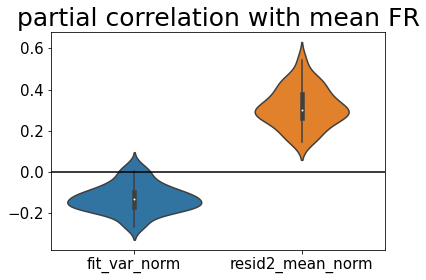

In [125]:
%matplotlib inline
ax=sns.violinplot(data=pcorr_res_all_relevant)
ax.axhline(0,color='k')
ax.set_title('partial correlation with mean FR')

In [95]:
allcorr_res_all

tot_var    mean fit_var resid2_mean  \
e13_26m1_210913 tot_var                 -   0.000   0.000       0.000   
                mean                0.611       -   0.000       0.000   
                fit_var             0.877   0.327       -       0.000   
                resid2_mean         0.813   0.749   0.432           -   
                fit_var_ratio       0.279  -0.171   0.544      -0.136   
...                                   ...     ...     ...         ...   
e16_1f1_200824  fit_var_ratio       0.233  -0.181   0.552      -0.237   
                resid2_mean_ratio  -0.233   0.181  -0.552       0.237   
                tot_var_norm        0.742   0.151   0.869       0.257   
                fit_var_norm        0.583  -0.014   0.883      -0.026   
                resid2_mean_norm     0.52   0.427   0.122       0.733   

                                  fit_var_ratio resid2_mean_ratio  \
e13_26m1_210913 tot_var                   0.000             0.000   
                mean                      0.000             0.000   
                fit_var                   0.000             0.000   
                resid2_mean               0.000             0.000   
                fit_var_ratio                 -                0.   
...                                         ...               ...   
e16_1f1_200824  fit_var_ratio                 -                0.   
                resid2_mean_ratio          -1.0                 -   
                tot_var_norm              0.475            -0.475   
                fit_var_norm              0.668            -0.668   
                resid2_mean_norm         -0.384             0.384   

                                  tot_var_norm fit_var_norm resid2_mean_norm  
e13_26m1_210913 tot_var                  0.000        0.000            0.000  
                mean                     0.490        0.005            0.000  
                fit_var                  0.000        0.000            0.000  
                resid2_mean              0.000        0.258            0.000  
                fit_var_ratio            0.000        0.000            0.666  
...                                        ...          ...              ...  
e16_1f1_200824  fit_var_ratio            0.000        0.000            0.002  
                resid2_mean_ratio        0.000        0.000            0.002  
                tot_var_norm                 -        0.000            0.003  
                fit_var_norm             0.924            -            0.874  
                resid2_mean_norm         0.364        -0.02                -  

[495 rows x 9 columns]

In [114]:
allcorr_res_all_relevant = allcorr_res_all['mean'].unstack()[['fit_var','resid2_mean','fit_var_ratio','resid2_mean_ratio','tot_var_norm','fit_var_norm','resid2_mean_norm']]
allcorr_res_all_relevant = allcorr_res_all_relevant.astype(float)



In [115]:
allcorr_res_all_relevant

,fit_var,resid2_mean,fit_var_ratio,resid2_mean_ratio,tot_var_norm,fit_var_norm,resid2_mean_norm
e13_26m1_210913,0.327,0.749,-0.171,0.171,-0.025,-0.101,0.219
e15_13f1_220117,0.346,0.719,-0.188,0.188,0.182,-0.005,0.397
e15_13f1_220118,0.267,0.659,-0.267,0.267,0.028,-0.119,0.298
e15_13f1_220119,0.280,0.660,-0.206,0.206,0.063,-0.084,0.292
e15_13f1_220120,0.275,0.722,-0.270,0.270,0.002,-0.142,0.271
e13_26m1_211019,0.465,0.677,-0.115,0.115,0.110,-0.035,0.290
e13_16f1_210328,0.198,0.681,-0.269,0.269,-0.040,-0.132,0.304
e13_26m1_211116,0.274,0.737,-0.206,0.206,-0.006,-0.091,0.256
e16_3m2_211213,0.135,0.698,-0.272,0.272,-0.053,-0.150,0.284
e16_3m1_210111,0.156,0.655,-0.170,0.170,0.034,-0.111,0.269


In [109]:
allcorr_res_all_relevant

,fit_var,resid2_mean,fit_var_ratio,resid2_mean_ratio,tot_var_norm,fit_var_norm,resid2_mean_norm
e13_26m1_210913,0.327,0.749,-0.171,0.171,-0.025,-0.101,0.219
e15_13f1_220117,0.346,0.719,-0.188,0.188,0.182,-0.005,0.397
e15_13f1_220118,0.267,0.659,-0.267,0.267,0.028,-0.119,0.298
e15_13f1_220119,0.28,0.66,-0.206,0.206,0.063,-0.084,0.292
e15_13f1_220120,0.275,0.722,-0.27,0.27,0.002,-0.142,0.271
e13_26m1_211019,0.465,0.677,-0.115,0.115,0.11,-0.035,0.29
e13_16f1_210328,0.198,0.681,-0.269,0.269,-0.04,-0.132,0.304
e13_26m1_211116,0.274,0.737,-0.206,0.206,-0.006,-0.091,0.256
e16_3m2_211213,0.135,0.698,-0.272,0.272,-0.053,-0.15,0.284
e16_3m1_210111,0.156,0.655,-0.17,0.17,0.034,-0.111,0.269


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'fit_var'),
  Text(1, 0, 'resid2_mean'),
  Text(2, 0, 'fit_var_ratio'),
  Text(3, 0, 'resid2_mean_ratio'),
  Text(4, 0, 'tot_var_norm'),
  Text(5, 0, 'fit_var_norm'),
  Text(6, 0, 'resid2_mean_norm')])

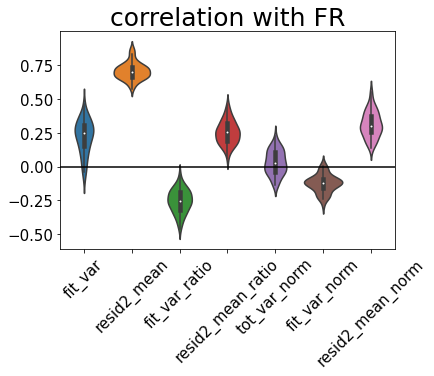

In [126]:
ax=sns.violinplot(data=allcorr_res_all_relevant)
ax.axhline(0,color='k')
ax.set_title('correlation with FR')
plt.xticks(rotation=45)

In [44]:
corr_res = post_decomp_corr(var_decomp_res)

In [46]:
corr_res

{'all_corr':                   tot_var    mean fit_var resid2_mean fit_var_ratio  \
 tot_var                 -   0.000   0.000       0.000         0.000   
 mean                0.588       -   0.000       0.000         0.002   
 fit_var             0.874   0.303       -       0.001         0.000   
 resid2_mean         0.647    0.71   0.195           -         0.000   
 fit_var_ratio       0.232  -0.183    0.45      -0.237             -   
 resid2_mean_ratio  -0.232   0.183   -0.45       0.237          -1.0   
 tot_var_norm        0.808   0.209   0.789       0.393         0.489   
 fit_var_norm        0.658   0.032   0.825       0.034         0.682   
 resid2_mean_norm     0.53   0.426   0.136       0.855        -0.271   
 
                   resid2_mean_ratio tot_var_norm fit_var_norm resid2_mean_norm  
 tot_var                       0.000        0.000        0.000            0.000  
 mean                          0.002        0.000        0.581            0.000  
 fit_var            

In [40]:
decompose_variability_onetrialtype(Xhat,fr_trial).rcorr()

,tot_var,mean,fit_var,resid2_mean,fit_var_ratio,resid2_mean_ratio,tot_var_norm,fit_var_norm,resid2_mean_norm
tot_var,-,***,***,***,***,***,***,***,***
mean,0.648,-,***,***,***,***,***,,***
fit_var,0.838,0.346,-,***,***,***,***,***,***
resid2_mean,0.727,0.719,0.234,-,***,***,***,,***
fit_var_ratio,0.191,-0.188,0.449,-0.224,-,***,***,***,***
resid2_mean_ratio,-0.191,0.188,-0.449,0.224,-1.0,-,***,***,***
tot_var_norm,0.738,0.182,0.72,0.409,0.48,-0.48,-,***,***
fit_var_norm,0.557,-0.005,0.763,0.034,0.701,-0.701,0.885,-,**
resid2_mean_norm,0.581,0.397,0.174,0.815,-0.229,0.229,0.553,0.103,-


In [35]:
Xhat.var(axis=1).loc[0,1] ==Xhat.loc[0,1].var(axis=1)

31   0    True
     1    True
32   0    True
34   0    True
35   0    True
          ... 
368  0    True
370  0    True
373  1    True
374  0    True
376  0    True
Length: 299, dtype: bool

In [27]:
var_decomp_res = decompose_variability_onetrialtype(Xhat_one,fr_trial_one)

In [12]:
var_decomp_res[['mean','fit_var','resid2_mean']].pcorr()

,mean,fit_var,resid2_mean
mean,1.000000,-0.105521,0.701919
fit_var,-0.105521,1.000000,0.430271
resid2_mean,0.701919,0.430271,1.000000


In [29]:
var_decomp_res[['mean','fit_var_norm','resid2_mean_norm']].pcorr()

,mean,fit_var_norm,resid2_mean_norm
mean,1.000000,0.014399,0.425347
fit_var_norm,0.014399,1.000000,0.034232
resid2_mean_norm,0.425347,0.034232,1.000000


In [31]:
var_decomp_res.rcorr()

,tot_var,mean,fit_var,resid2_mean,fit_var_ratio,resid2_mean_ratio,tot_var_norm,fit_var_norm,resid2_mean_norm
tot_var,-,***,***,***,***,***,***,***,***
mean,0.588,-,***,***,**,**,***,,***
fit_var,0.874,0.303,-,***,***,***,***,***,*
resid2_mean,0.647,0.71,0.195,-,***,***,***,,***
fit_var_ratio,0.232,-0.183,0.45,-0.237,-,***,***,***,***
resid2_mean_ratio,-0.232,0.183,-0.45,0.237,-1.0,-,***,***,***
tot_var_norm,0.808,0.209,0.789,0.393,0.489,-0.489,-,***,***
fit_var_norm,0.658,0.032,0.825,0.034,0.682,-0.682,0.906,-,
resid2_mean_norm,0.53,0.426,0.136,0.855,-0.271,0.271,0.464,0.045,-


In [117]:
var_decomp_res.pcorr()

,tot_var,mean,fit_var,resid2_mean,fit_var_ratio,resid2_mean_ratio,tot_var_norm,fit_var_norm,resid2_mean_norm
tot_var,1.000000,0.832304,0.311597,-0.675097,0.117402,-0.117402,0.848285,-0.504676,0.705960
mean,0.832304,1.000000,-0.390775,0.663927,-0.123819,0.123819,-0.653529,0.432242,-0.572679
fit_var,0.311597,-0.390775,1.000000,0.911359,0.225396,-0.225396,-0.339637,0.673799,-0.595445
resid2_mean,-0.675097,0.663927,0.911359,1.000000,-0.124137,0.124137,0.631147,-0.741740,0.768099
fit_var_ratio,0.117402,-0.123819,0.225396,-0.124137,1.000000,1.000000,-0.042142,0.248899,-0.183483
resid2_mean_ratio,-0.117402,0.123819,-0.225396,0.124137,1.000000,1.000000,0.042142,-0.248899,0.183483
tot_var_norm,0.848285,-0.653529,-0.339637,0.631147,-0.042142,0.042142,1.000000,0.635195,-0.858914
fit_var_norm,-0.504676,0.432242,0.673799,-0.741740,0.248899,-0.248899,0.635195,1.000000,0.941114
resid2_mean_norm,0.705960,-0.572679,-0.595445,0.768099,-0.183483,0.183483,-0.858914,0.941114,1.000000


In [30]:
var_decomp_res[['mean','fit_var_ratio','resid2_mean_ratio','fit_var_norm','resid2_mean_norm']].rcorr()

,mean,fit_var_ratio,resid2_mean_ratio,fit_var_norm,resid2_mean_norm
mean,-,**,**,,***
fit_var_ratio,-0.183,-,***,***,***
resid2_mean_ratio,0.183,-1.0,-,***,***
fit_var_norm,0.032,0.682,-0.682,-,
resid2_mean_norm,0.426,-0.271,0.271,0.045,-


In [32]:
var_decomp_res['tot_var']

3    0     0.797904
27   0    19.384251
29   0    28.033552
     1    11.393345
     2    17.257641
            ...    
463  1     0.581615
465  0     4.456872
475  0    11.631650
476  0     4.456144
480  0    12.885234
Length: 386, dtype: float64

In [26]:
fr_trial_one.var(axis=1)

3    0     0.797904
27   0    19.384251
29   0    28.033552
     1    11.393345
     2    17.257641
            ...    
463  1     0.581615
465  0     4.456872
475  0    11.631650
476  0     4.456144
480  0    12.885234
Length: 386, dtype: float64

In [24]:
Xhat_one

0         1         2         3         4         5         6   \
3   0  0.176031  0.176031  0.176031  0.176031  0.176031  0.176031  0.176031   
27  0  0.241632  0.241632  0.241632  0.241632  0.241632  0.241632  0.241632   
29  0  0.567584  0.567584  0.567584  0.567584  0.567584  0.567584  0.567584   
    1  0.351142  0.351142  0.351142  0.351142  0.351142  0.351142  0.351142   
    2  0.352298  0.352298  0.352298  0.352298  0.352298  0.352298  0.352298   
...         ...       ...       ...       ...       ...       ...       ...   
463 1  0.380894  0.380894  0.380894  0.380894  0.380894  0.380894  0.380894   
465 0  0.133564  0.133564  0.133564  0.133564  0.133564  0.133564  0.133564   
475 0  0.556584  0.556584  0.556584  0.556584  0.556584  0.556584  0.556584   
476 0  1.000000  0.151054  0.151054  0.151054  0.151054  0.151054  0.151054   
480 0  0.297578  0.297578  0.297578  0.297578  0.297578  0.297578  0.297578   

             7         8         9   ...        27        28        29  \
3   0  0.176031  0.176031  0.176031  ...  0.572069  0.572069  0.572069   
27  0  0.241632  0.241632  0.241632  ...  0.463675  0.463675  0.463675   
29  0  0.567584  0.567584  0.567584  ...  0.177107  0.177107  0.177107   
    1  0.351142  0.351142  0.351142  ...  0.583119  0.583119  0.583119   
    2  0.352298  0.352298  0.629652  ...  0.629652  0.233678  0.233678   
...         ...       ...       ...  ...       ...       ...       ...   
463 1  0.380894  0.380894  0.380894  ...  0.188275  0.188275  0.188275   
465 0  0.133564  0.133564  0.133564  ...  0.096261  0.096261  0.096261   
475 0  0.243060  0.243060  0.243060  ...  0.243060  0.243060  0.243060   
476 0  0.151054  0.151054  0.151054  ...  0.151054  0.151054  0.151054   
480 0  0.297578  0.297578  0.297578  ...  0.654293  0.654293  0.654293   

             30        31        32  33  34  35  36  
3   0  0.572069  0.572069  0.572069 NaN NaN NaN NaN  
27  0  0.463675  0.463675  0.463675 NaN NaN NaN NaN  
29  0  0.177107  0.177107  0.177107 NaN NaN NaN NaN  
    1  0.583119  0.583119  0.583119 NaN NaN NaN NaN  
    2  0.233678  0.233678  0.233678 NaN NaN NaN NaN  
...         ...       ...       ...  ..  ..  ..  ..  
463 1  0.188275  0.188275  0.889220 NaN NaN NaN NaN  
465 0  0.096261  0.096261  0.096261 NaN NaN NaN NaN  
475 0  0.243060  0.243060  0.243060 NaN NaN NaN NaN  
476 0  0.151054  0.151054  0.151054 NaN NaN NaN NaN  
480 0  0.654293  0.654293  0.654293 NaN NaN NaN NaN  

[386 rows x 37 columns]